### 0. Импорт библиотек

In [1073]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import (
  chi2_contingency,
  ks_2samp,
  mannwhitneyu,
  norm
)

pd.set_option('future.no_silent_downcasting', True)

### 1. Анализ структуры данных и их предобработка

#### 1.1. Создание датафрейма и загрузка данных из файла

In [1074]:
df = pd.read_csv('data/marketing.csv', index_col=0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [1075]:
print(f'В таблице {len(df)} запись')

В таблице 588101 запись


Таблица содержит семь столбцов:
- ```user id``` - идентификатор пользователя (уникальный);
- ```test group``` - признак показа рекламы или объявления (если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы);
- ```converted``` - признак покупки продукта (если человек купил продукт, то True, иначе False);
- ```total ads``` - количество рекламы, увиденной человеком;
- ```most ads day``` - день, в который человек увидел наибольшее количество рекламы;
- ```most ads hour``` - час дня, в который человек увидел наибольшее количество рекламы.

В таблице ```588101``` запись.

#### 1.2. Получение сведений о структуре датасета

In [1076]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


#### 1.3. Переименование столбцов

In [1077]:
df = df.rename(columns={
  'user id': 'user_id',
  'test group': 'test_group',
  'total ads': 'total_ads',
  'most ads day': 'most_ads_day',
  'most ads hour': 'most_ads_hour'
})

df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


#### 1.4. Преобразование строкового типа столбца ```most_ads_day``` к числовому

In [1078]:
weekdays_nuumbers = {
  'Monday': 1,
  'Tuesday': 2,
  'Wednesday': 3,
  'Thursday': 4,
  'Friday': 5,
  'Saturday': 6,
  'Sunday' : 7
}

df['most_ads_day'] = df['most_ads_day'].replace(weekdays_nuumbers).astype(int)

#### 1.5. Преобразование объектного типа столбца ```test_group``` к категориальному

In [1079]:
df['test_group'] = df['test_group'].astype('category')

In [1080]:
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,1,20
1,1119715,ad,False,93,2,22
2,1144181,ad,False,21,2,18
3,1435133,ad,False,355,2,10
4,1015700,ad,False,276,5,14


In [1081]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user_id        588101 non-null  int64   
 1   test_group     588101 non-null  category
 2   converted      588101 non-null  bool    
 3   total_ads      588101 non-null  int64   
 4   most_ads_day   588101 non-null  int64   
 5   most_ads_hour  588101 non-null  int64   
dtypes: bool(1), category(1), int64(4)
memory usage: 23.6 MB


#### 1.6. Проверка данных на наличие пропусков

In [1082]:
df.isnull().sum() + df.eq('').sum()

user_id          0
test_group       0
converted        0
total_ads        0
most_ads_day     0
most_ads_hour    0
dtype: int64

#### 1.4. Проверка наличия пользователей, попавших в обе группы в процессе A/B-теста

In [1083]:
df_unique_users = df['user_id'].unique()
print(f'Количество уникальных пользователей {len(df_unique_users)}')

Количество уникальных пользователей 588101


In [1084]:
df_unique_groups = df['test_group'].unique()
print(f'Пользователи разделены на группы {df_unique_groups}')

Пользователи разделены на группы ['ad', 'psa']
Categories (2, object): ['ad', 'psa']


In [1085]:
# Второе решение проверки вхождения пользователей в несколько групп через группировку
user_group_counts = df.groupby('user_id')['test_group'].nunique()
duplicate_users = user_group_counts[user_group_counts > 1].index

#### 1.5. Выводы к предварительному анализу данных
- в датасете отсутствуют пропуски данных;
- так как столбец ```user_id``` содержит ```588101``` уникальных записей, что совпадает с общим числом записей, а столбец ```test_group``` содержит только два возможных значения ```ad``` и ```psa``` можно сказать, что в датасете отсутствуют пользователи, попавшие в несколько тестовых групп;

### 2. Первичный анализ результатов A/B-тестирования

#### 2.1. Рассчет количества посещений сайта, суммарного количество совершённых покупок и среднего количества показов рекламы для каждой группы

In [1086]:
df_site_groups = df.groupby([ 'test_group' ], observed=True) \
  .agg({ 'user_id':'count', 'converted':'sum', 'total_ads':'mean' }) \
  .rename(columns={ 'user_id': 'users_count', 'converted': 'buyers_count', 'total_ads': 'mean_ads' })

df_site_groups

,users_count,buyers_count,mean_ads
test_group,,,
ad,564577,14423,24.823365
psa,23524,420,24.761138


#### 2.2. Рассчет конверсий

In [1087]:
# Рассчитаем процент совершивших покупку в каждой группе и добавим в новый столбец
df_site_groups['conversion'] = df_site_groups['buyers_count'] / df_site_groups['users_count']
df_site_groups

,users_count,buyers_count,mean_ads,conversion
test_group,,,,
ad,564577,14423,24.823365,0.025547
psa,23524,420,24.761138,0.017854


#### 2.3. Выводы к первичному анализу результатов A/B-тестирования
- выборки являются несбалансированными, так как количество посетителей, которым показывали рекламу (```564577``` человек) в ```24``` раза превышает тех, кто видел объявление государственной службы (```23524``` человека);
- среднее количество показов рекламы почти одинаково в обеих группах и ссоставляет примерно ```24``` показа, что является логичным, так как в данном маркетинговом исседовании проверялось не количество показов рекламы, а ее содержание, то есть для пользователя ```отличме заключалось в содержании: рекламное объявление или объявление государственной службы```;
- конверсия составляет ```2,55%``` в группе, где пользователи видели рекламу, и ```1,78%``` для группы, которой показывали объявление государственной службы, что при первичном анализе указывает на большую эффективность показа рекламного объявления, чем объявления государственной службы;

### 3.  Статистический анализ результатов A/B-тестирования

#### 3.1. Проверка данных на нормальность

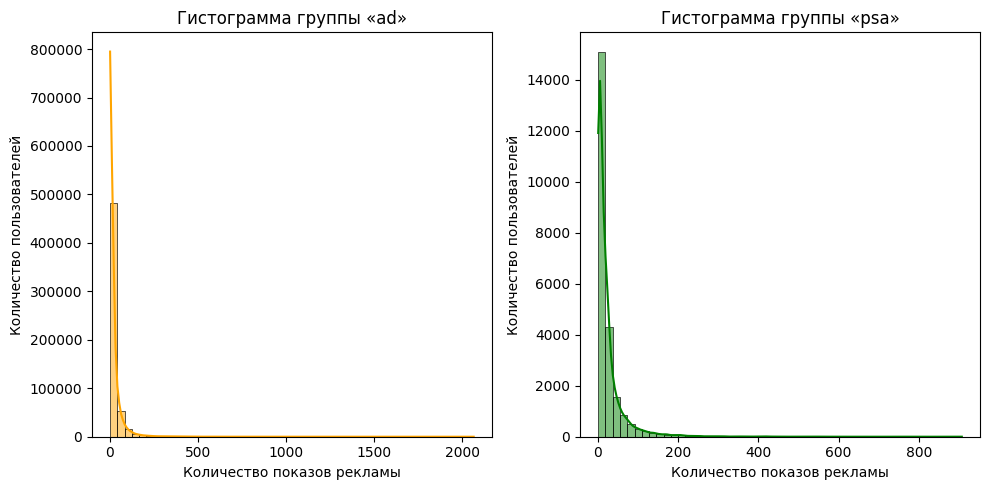

In [1088]:
df_ad_group = df[df['test_group'] == 'ad']['total_ads']
df_psa_group = df[df['test_group'] == 'psa']['total_ads']

plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
sns.histplot(df_ad_group, kde=True, bins=50, ax=ax1, color='orange')
ax1.set_title('Гистограмма группы «ad»')
ax1.set_xlabel('Количество показов рекламы')
ax1.set_ylabel('Количество пользователей')


ax2 = plt.subplot(1, 2, 2)
sns.histplot(df_psa_group, kde=True, bins=50, ax=ax2, color='green')
ax2.set_title('Гистограмма группы «psa»')
ax2.set_xlabel('Количество показов рекламы')
ax2.set_ylabel('Количество пользователей')

plt.tight_layout()
plt.show()

#### 3.2. Тест Колмогорова-Смирнова

In [1089]:
test_value = ks_2samp(df_ad_group, df_psa_group)
print(f"p-value={test_value.pvalue}")

p-value=2.342650880233848e-31


#### 3.3. Формулировка статистических гипотез и выбор статистических тестов для их проверки

##### 3.3.1. Критерий хи-квадрат для конверсии
- нулевая гипотеза (H0) - ```конверсии``` для группы «ad», которой показывали рекламу и группы «psa», видевшей объявления государственной службы, ```не различаются```;
- альтернативная гипотеза (H1) - ```конверсии``` для групп «ad» и «psa» ```различаются```.

##### 3.3.2. U-тест Манна-Уитни для среднего количества показов рекламы
- нулевая гипотеза (H0) - среднее количество показов рекламы для группы «ad», которой показывали рекламу и группы «psa», видевшей объявления государственной службы,  одинаково;
- альтернативная гипотеза (H1) - среднее количество рекламы между группами «ad» и «psa» различается.

##### 3.3.3. Построение таблицы сопряженности для теста ```хи-квадрат```

In [1090]:
crosstab = pd.crosstab(df['test_group'], df['converted'])
chi2, p_value, _, _ = chi2_contingency(crosstab)

print(f'Критерий хи-квадрат: chi2={chi2}, p-value={p_value}')

Критерий хи-квадрат: chi2=54.005823883685245, p-value=1.9989623063390075e-13


##### 3.3.4. Вычисление *U*-критерия Манна-Уитни для среднего количества показов рекламы

In [1091]:
u_stat, p_value = mannwhitneyu(df_ad_group, df_psa_group)
print(f'U-критерий Манна-Уитни: p-value={p_value}')

U-критерий Манна-Уитни: p-value=4.6909108547205694e-11


#### 3.4. Выводы к первичному анализу результатов A/B-тестирования

- по гисторгаммам распределение можно сказать, что данные распределены не нормальные, а имеют логарифмически-нормальное распределение;
- тест Колмогорова-Смирнова ```p-value < 0,05``` также показывает, что группы имеют различные распределения и не не являются нормальными;
- тест хи-квадрат ```p-value << 0,05``` позволяет отвергуть нулевую гипотезу о том, что между группами нет различий и, соответсвенно, принять альтернативная гипотезу, что что различие в конверсиях между группами статистически значимо;
- значение u-критерия Манна-Уитни ```p-value < 0,05``` показывает, что различия между группами статистически значимы.

### 4. Доверительные интервалы

#### 4.1. Построение доверительных интервалов

In [1092]:
def get_conversion_interval(success, total, alpha=0.05):
  lower, upper = proportion_confint(success, total, alpha=alpha, method='normal')
  return lower, upper

df_site_groups['conversion_interval'] = df_site_groups.apply(
  lambda row: get_conversion_interval(row['buyers_count'], row['users_count']), axis=1
)

conversion_diff = df_site_groups['conversion']['ad'] - df_site_groups['conversion']['psa']

std_error = np.sqrt(
  df_site_groups['conversion']['ad'] * (1 - df_site_groups['conversion']['ad']) / df_site_groups['users_count']['ad'] +
  df_site_groups['conversion']['psa'] * (1 - df_site_groups['conversion']['psa']) / df_site_groups['users_count']['psa']
)

z_score = 1.96

conversion_diff_interval = (
  conversion_diff - z_score * std_error,
  conversion_diff + z_score * std_error
)

def get_mean_interval(data, alpha=0.05):
  mean = data.mean()
  std_dev = data.std()
  n = len(data)

  std_error = std_dev / np.sqrt(n)
  z_score = norm.ppf(1 - alpha / 2)
  margin_of_error = z_score * std_error

  return mean - margin_of_error, mean + margin_of_error

ad_interval = get_mean_interval(df_ad_group)
psa_interval = get_mean_interval(df_psa_group)

print(f'Доверительные интервалы для конверсии в группе «ad»: {df_site_groups["conversion_interval"]['ad']}')
print(f'Доверительные интервалы для конверсии в группе «psa»: {df_site_groups["conversion_interval"]['psa']}\n')

print(f'Доверительный интервал для разницы конверсий: {[ float(x) for x in conversion_diff_interval ]}\n')

print(f'Доверительный интервал для среднего количества рекламы группе «ad»: {[ float(x) for x in ad_interval ]}')
print(f'Доверительный интервал для среднего количества рекламы в группе «psa»: {[ float(x) for x in psa_interval ]}')

Доверительные интервалы для конверсии в группе «ad»: (0.0251349995427061, 0.025958119730661394)
Доверительные интервалы для конверсии в группе «psa»: (0.016161914715211324, 0.019546298173753137)

Доверительный интервал для разницы конверсий: [0.00595090043017032, 0.009434005954232714]

Доверительный интервал для среднего количества рекламы группе «ad»: [24.70924317886855, 24.937487027994283]
Доверительный интервал для среднего количества рекламы в группе «psa»: [24.213425925783053, 25.308849197495302]


#### 4.2. Выводв к анализу доверительных интервалов
- доверительные интервалы для конверсий не перекрываются, что показывает статистическую значимость различий между группами;
- разница в конверсиях ```0.60%``` является значимой для бизнеса;
- доверительные интервалы для среднего количества рекламы пересекаются, что показывает не значительную статистическое различие между группами.

### 5. Соответствие выводов бизнес-вопросам
- присутствует статистически значимое различие в конверсии между группами: более высокая конверсия для группы «ad»;
- различие в конверсии между группами не связано с количеством рекламы, что, как уже выше говорилось, логично, поскольку в даном исследовании задачей было сравнение не количества показов, а содержание объявлений. Из этого можно предположить, что пользователи видевшие рекламные объявления совершили большен покупок, чем те, кто видел объявления государственной службы;
- в качестве рекомендации можно пожелать сделать выборку сбалансированной, с равным количеством представителей разных групп.